# <center>Project 1</center>

## Project members: Andrew, Tim, Mide

## Points to hit:
* Point 1: Correlation between highest grossing movies and critic/user ratings
* Point 2: Correlation between the rating of a movie and the total gross
* Point 3: Correlation between movie genres and total gross
---

## Set Prerequisites
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

sns.set_theme(style='darkgrid')

%matplotlib inline

## Creating the Master Dataframe
---

#### Load in the original Rotten Tomatoes movie dataframe

In [2]:
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', sep='\t')
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


#### Create a new dataframe with relevant columns

In [3]:
rt_new = rt_movie_info[['rating' , 'box_office' , 'genre', 'director']].copy()
rt_new.head()

,rating,box_office,genre,director
0,R,NaN,Action and Adventure|Classics|Drama,William Friedkin
1,R,"600,000",Drama|Science Fiction and Fantasy,David Cronenberg
2,R,NaN,Drama|Musical and Performing Arts,Allison Anders
3,R,NaN,Drama|Mystery and Suspense,Barry Levinson
4,NR,NaN,Drama|Romance,Rodney Bennett


#### Drop null values

In [4]:
rt_new.dropna(subset=['box_office'], inplace = True)
rt_new.dropna(subset=['director'], inplace = True)

rt_new.head()

,rating,box_office,genre,director
1,R,"600,000",Drama|Science Fiction and Fantasy,David Cronenberg
6,PG-13,"41,032,915",Comedy,Jake Kasdan
7,R,"224,114",Drama,Ray Lawrence
8,R,"134,904",Drama,Taylor Hackford
15,R,"1,039,869",Comedy|Drama|Mystery and Suspense,George Hickenlooper


#### Clean the commas from box_office

In [5]:
rt_new['box_office'] = rt_new['box_office'].str.replace(',' , '')
rt_new.head()

,rating,box_office,genre,director
1,R,600000,Drama|Science Fiction and Fantasy,David Cronenberg
6,PG-13,41032915,Comedy,Jake Kasdan
7,R,224114,Drama,Ray Lawrence
8,R,134904,Drama,Taylor Hackford
15,R,1039869,Comedy|Drama|Mystery and Suspense,George Hickenlooper


#### Cast box_office column to type int

In [6]:
rt_new['box_office'] = rt_new['box_office'].astype(int)
rt_new['box_office']

1         600000
6       41032915
7         224114
8         134904
15       1039869
          ...   
1536      581813
1537     1320005
1541    25335935
1542     1416189
1545       59371
Name: box_office, Length: 299, dtype: int32

#### Save cleaned master dataframe

In [7]:
rt_new.to_csv('data/master.csv', encoding='utf-8', index=False)

## Open our new master dataframe for use
---

In [8]:
master = pd.read_csv('data/master.csv')
master.head()

,rating,box_office,genre,director
0,R,600000,Drama|Science Fiction and Fantasy,David Cronenberg
1,PG-13,41032915,Comedy,Jake Kasdan
2,R,224114,Drama,Ray Lawrence
3,R,134904,Drama,Taylor Hackford
4,R,1039869,Comedy|Drama|Mystery and Suspense,George Hickenlooper


---
# <center>POINT 1</center>
---

#### Create dataframe with relevant columns, sort and group

In [9]:
d_earning = master[['director', 'box_office', 'genre']]

d_earning.groupby(['director']).sum().reset_index()
d_earning.sort_values('box_office', inplace=True, ascending=False, ignore_index=True)
d_earning.head()

,director,box_office,genre
0,Mel Gibson,368000000,Drama
1,Peter Jackson,303001229,Action and Adventure|Science Fiction and Fantasy
2,Sam Mendes,299300000,Action and Adventure|Mystery and Suspense
3,Jay Roach,279167575,Comedy
4,Chris Columbus,261835892,Kids and Family|Science Fiction and Fantasy


#### Create separate dataframe with top 20 earning directors

In [10]:
top20_d_earning = d_earning[:20]
top20_d_earning.head()

,director,box_office,genre
0,Mel Gibson,368000000,Drama
1,Peter Jackson,303001229,Action and Adventure|Science Fiction and Fantasy
2,Sam Mendes,299300000,Action and Adventure|Mystery and Suspense
3,Jay Roach,279167575,Comedy
4,Chris Columbus,261835892,Kids and Family|Science Fiction and Fantasy


#### Use lambda to display currency ticks properly

In [11]:
top20_d_earning['box_office'] = top20_d_earning['box_office'].apply(lambda x: x/1000000)

#### Visualize

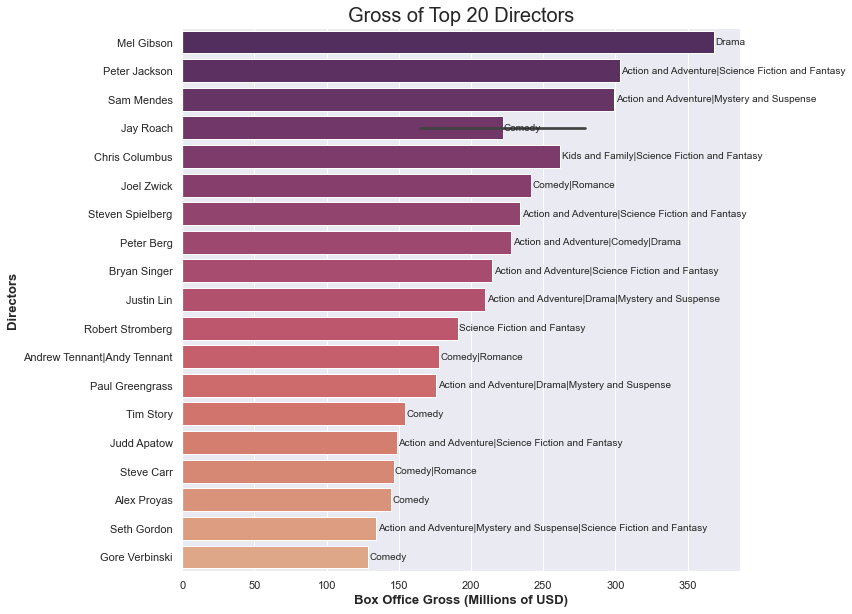

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

#plot top 20 data onto a bar plot
chart = sns.barplot(y='director',x='box_office', orient='h', palette= 'flare_r',  data= top20_d_earning)
#setting title and labels
chart.set_title('Gross of Top 20 Directors', fontsize = 20)
chart.set_ylabel('Directors', fontsize = 13, weight = 'bold')
chart.set_xlabel('Box Office Gross (Millions of USD)', fontsize = 13, weight = 'bold');

i = 0
for p in chart.patches:
    width = p.get_width()    # get bar length
    chart.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{}'.format(top20_d_earning['genre'][i]), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
    i += 1

---
# <center>POINT 2</center>
---

#### Create dataframe with relevant columns, and drop unneeded rows

In [13]:
rating_gross = master[['rating', 'box_office']]

rating_gross.drop(rating_gross[rating_gross['rating'] == 'NR'].index, inplace=True)
rating_gross.drop(rating_gross[rating_gross['rating'] == 'NC17'].index, inplace=True)
rating_gross.drop(rating_gross[rating_gross['rating'] == 'G'].index, inplace=True)

#### Use lambda to display currency ticks properly

In [14]:
rating_gross['box_office'] = rating_gross['box_office'].apply(lambda x: x/1000000)

#### Visualize

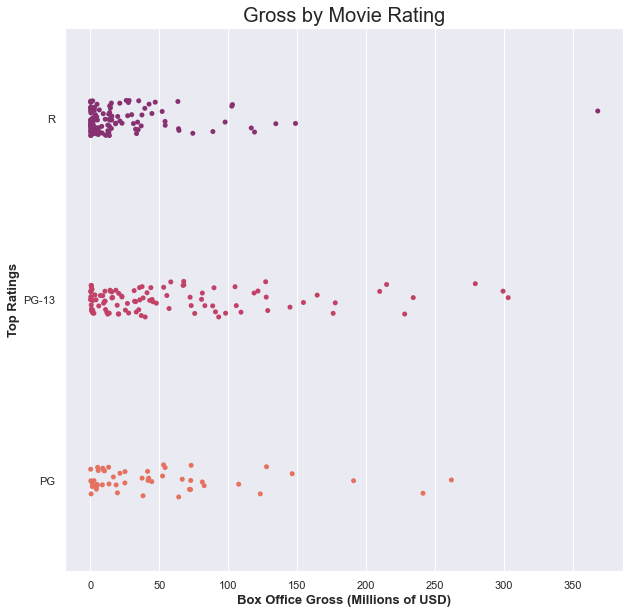

In [15]:
f, ax = plt.subplots(figsize=(10, 10))

sns.stripplot(x="box_office", y="rating", data=rating_gross, palette= 'flare_r')

ax.set_xlabel('Box Office Gross (Millions of USD)', fontsize = 13, weight = 'bold')
ax.set_ylabel('Top Ratings', fontsize = 13, weight = 'bold')
ax.set_title('Gross by Movie Rating', fontsize = 20);

---
# <center>POINT 3</center>
---

#### Create dataframe with relevant columns, calculate sum of box_office and group

In [16]:
g_gross = master[['genre', 'box_office']]

aggregation_functions = {'box_office': 'sum'}
gg_new = g_gross.groupby(g_gross['genre']).aggregate(aggregation_functions).reset_index()
gg_new.sort_values('box_office', inplace=True, ascending=False, ignore_index=True)


#### Create top 20 dataframe

In [17]:
g_gross_20 = gg_new[:20]

#### Use lambda to display currency ticks properly

In [18]:
g_gross_20['box_office'] = g_gross_20['box_office'].apply(lambda x: x/1000000)

#### Visualize

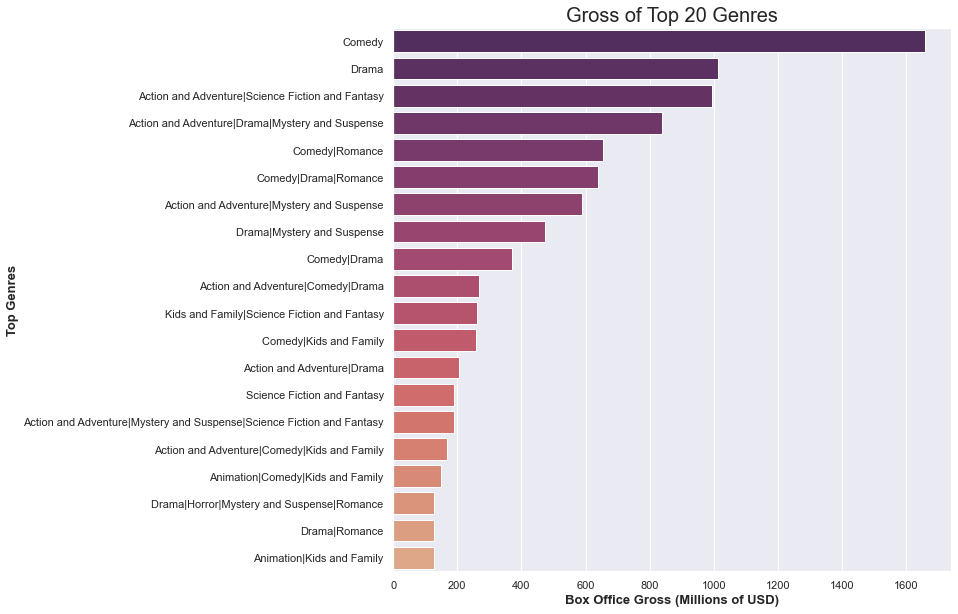

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(y =g_gross_20['genre'][:20],x = g_gross_20['box_office'], orient = 'h', palette = 'flare_r')

ax.set_title('Gross of Top 20 Genres', fontsize =  20)
ax.set_xlabel('Box Office Gross (Millions of USD)', fontsize = 13, weight = 'bold')
ax.set_ylabel('Top Genres', fontsize = 13, weight = 'bold');